<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab7_mbrl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Model Based Reinforcement Learning
In this lab, we will star practicing about Gaussian Process and then we will apply it to Model Based RL (MBRL).

## Exercise 1: Intro to Gaussian Processes with GPyTorch

***Objective:*** Build intuition for Gaussian Processes (GPs) by:
- Fitting an **exact GP** to noisy 1D data
- Visualizing **posterior mean + uncertainty**
- Understanding the effects of **noise** and **lengthscale**
- Exploring **extrapolation** (add a linear mean)
- Trying a **sparse GP** with inducing points (optional)

For more information. Check the GP Tutorial: https://docs.gpytorch.ai/en/v1.6.0/examples/01_Exact_GPs/Simple_GP_Regression.html

---

### Data
Use a 1D function with noise:
- f(x) = sin(2πx) + 0.3 * sin(6πx) + 3
- x ∈ [-1.0, 1.0]
- Add Gaussian noise σ_n (try 0.05 and 0.2)

---

## Tasks

### Part A — Exact GP regression (RBF kernel)
1. Implement an **ExactGP** model in GPyTorch:
   - Mean: `ZeroMean`
   - Covariance: `ScaleKernel(RBFKernel)`
   - Likelihood: `GaussianLikelihood`
2. Train by **maximizing log marginal likelihood** (Adam).
3. Plot:
   - Training points
   - Posterior mean
   - 95% confidence band

### Part B — Hyperparameters & data noise
1. Vary the **noise level** in the data (e.g., 0.05 vs 0.2).
2. For each setting, re-train the GP and report learned:
   - `likelihood.noise` (data noise)
   - `kernel.lengthscale`
3. Discuss how these affect smoothness and the width of uncertainty.

### Part C — Extrapolation behavior
1. **Hold out** the rightmost region (e.g., train on x ∈ [-1, 0.5], test on x ∈ (0.5, 1]).
2. Show how the posterior behaves outside the training region.
3. Add a **linear mean** (or `ConstantMean + LinearMean`) and compare extrapolation.

### Part D — (Graduate level) Sparse GP with inducing points
1. Replace Exact GP with **variational inducing-point GP** (SVGP) using `gpytorch.models.ApproximateGP`.
2. Choose M = 32 or 64 inducing points spread across x.
3. Compare posterior to the exact GP.
4. Plot N (number of samples) Vs training time for SVGP and ExactGP

---

## Deliverables
- Code for Parts A–C (Part D for grad students)
- Plots:
  - Mean ± 2 std band with training data
  - Effect of noise and lengthscale
  - Extrapolation comparison (zero vs linear/constant mean)
- Short write-up (≤1 page, as a cell in the notebook):
  - What did increasing noise do to learned hyperparameters and uncertainty?
  - How does the kernel lengthscale affect fit and confidence?
  - Why does the GP behave the way it does when extrapolating? How did the mean function change that?
  - (Grad level) Sparse vs Exact: trade-offs you observed

---

## Hints
- Normalize tensors to `float32` and move to GPU if available.
- Use `model.train(); likelihood.train()` for training, and `.eval()` for evaluation.
- For plotting uncertainty: `lower, upper = pred.confidence_region()`.
- Clip very small noise/lengthscale during early training if it becomes unstable.
- For SVGP, look at: `gpytorch.variational`, `gpytorch.mlls.VariationalELBO`.



In [ ]:
## Install required libraries
!pip -q install gpytorch torch matplotlib

### Part A — Exact GP regression (RBF kernel)

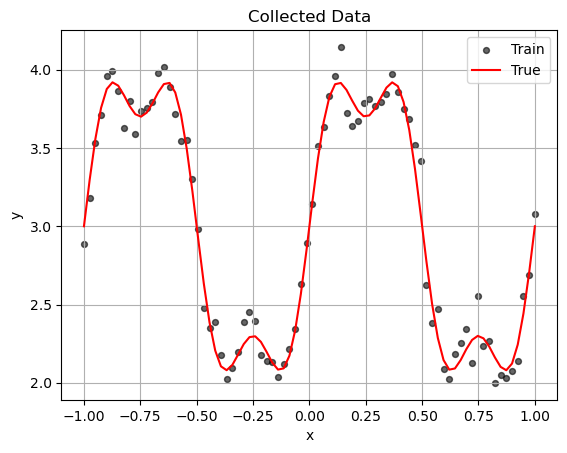

In [ ]:
import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.

# =======================
# Collecting DATA
# =======================
import torch, math
import gpytorch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Parameter for data generator
NOISE_STD = 0.1
N = 80

def f(x):
  return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3


# ---------- Data ----------
def make_data(n=80, noise_std=0.05, train_range=(-1.0, 1.0), holdout_right=False):
    x = torch.linspace(train_range[0], train_range[1], n)
    y_clean = f(x)
    y = y_clean + noise_std*torch.randn_like(y_clean)
    if holdout_right:
        mask = x <= 0.5
        return x[mask].unsqueeze(-1), y[mask], x.unsqueeze(-1), y
    else:
        return x.unsqueeze(-1), y, x.unsqueeze(-1), y

# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Plot data
plt.scatter(Xtr.cpu(), Ytr.cpu(), s=18, color='k', alpha=0.6, label='Train')
plt.plot(Xgrid.cpu(), f(Xgrid.cpu()), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()

In [ ]:
# ---------- Exact GP model ----------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # TODO (Part A): pick a mean; start with ZeroMean (try Constant/Linear in Part C)
        self.mean_module = gpytorch.means.ZeroMean()
        # TODO (Part A): kernel = ScaleKernel(RBFKernel)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def trainmodel(model, likelihood, Xtr, Ytr, training_iter=800):
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(Xtr)
        loss = -mll(output, Ytr)
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0 or i == 0:
            ls = model.covar_module.base_kernel.lengthscale.item()
            sn = likelihood.noise.item()
            print(f"iter {i+1:4d} | loss {loss.item():.3f} | lengthscale {ls:.3f} | noise {sn:.4f}")

# Likelihood + model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

iter    1 | loss 1.235 | lengthscale 0.668 | noise 0.6686
iter  200 | loss 0.312 | lengthscale 0.400 | noise 0.0625
iter  400 | loss 0.306 | lengthscale 0.414 | noise 0.0623
iter  600 | loss 0.305 | lengthscale 0.421 | noise 0.0623
iter  800 | loss 0.304 | lengthscale 0.425 | noise 0.0623


c:\Users\edwar\miniconda3\envs\rl\lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


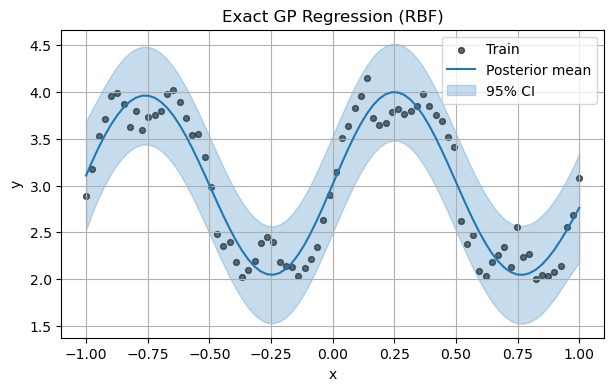

In [ ]:
# # ---------- Train (maximize log marginal likelihood) ----------
# training_iter = 800
# model.train()
# likelihood.train()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# for i in range(training_iter):
#     optimizer.zero_grad()
#     output = model(Xtr)
#     loss = -mll(output, Ytr)
#     loss.backward()
#     optimizer.step()

#     if (i + 1) % 200 == 0 or i == 0:
#         ls = model.covar_module.base_kernel.lengthscale.item()
#         sn = likelihood.noise.item()
#         print(f"iter {i+1:4d} | loss {loss.item():.3f} | lengthscale {ls:.3f} | noise {sn:.4f}")

trainmodel(model, likelihood, Xtr, Ytr, training_iter=800)


# ---------- Evaluate ----------
x2 = torch.linspace(-1, 1, N).to(device)
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x2))
    mean = pred.mean.cpu()
    lower, upper = pred.confidence_region()
    lower, upper = lower.cpu(), upper.cpu()

x2 = x2.cpu().squeeze()
Ytr_cpu = Ytr.cpu()
Xtr_cpu = Xtr.cpu().squeeze()

# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu, Ytr_cpu, s=18, color='k', alpha=0.6, label='Train')
plt.plot(x2, mean, label='Posterior mean', color='C0')
plt.fill_between(x2, lower, upper, alpha=0.25, label='95% CI', color='C0')
plt.title('Exact GP Regression (RBF)')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()


### Part B — Hyperparameters & data noise

- *Noise 0.05*

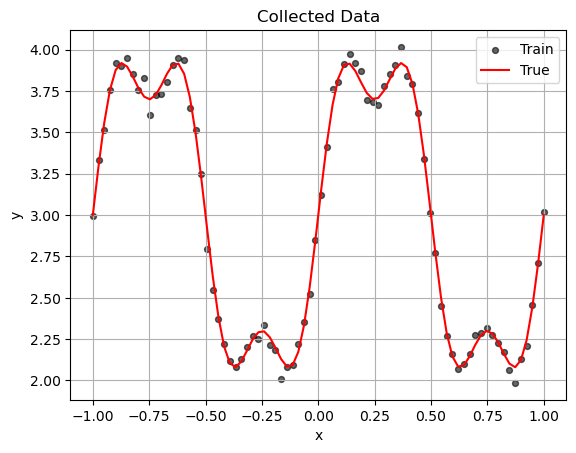

In [ ]:

# Parameter for data generator
NOISE_STD = 0.05
N = 80

# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Plot data
plt.scatter(Xtr.cpu(), Ytr.cpu(), s=18, color='k', alpha=0.6, label='Train')
plt.plot(Xgrid.cpu(), f(Xgrid.cpu()), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()

In [ ]:
# Likelihood + model
likelihood1 = gpytorch.likelihoods.GaussianLikelihood().to(device)
model1 = ExactGPModel(Xtr, Ytr, likelihood1).to(device)

iter    1 | loss 1.237 | lengthscale 0.668 | noise 0.6686
iter  200 | loss 0.221 | lengthscale 0.396 | noise 0.0510
iter  400 | loss 0.216 | lengthscale 0.408 | noise 0.0509
iter  600 | loss 0.214 | lengthscale 0.414 | noise 0.0509
iter  800 | loss 0.214 | lengthscale 0.418 | noise 0.0509


c:\Users\edwar\miniconda3\envs\rl\lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


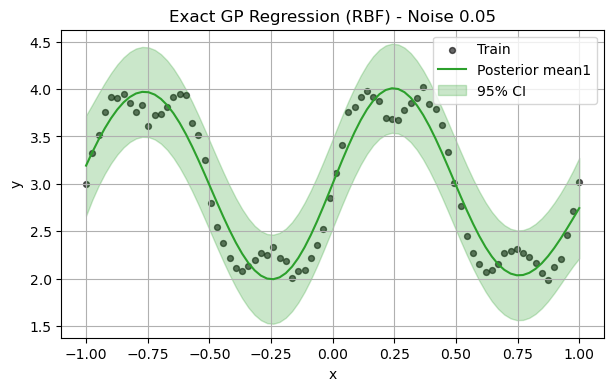

In [ ]:
# ---------- Train (maximize log marginal likelihood1) ----------
trainmodel(model1, likelihood1, Xtr, Ytr, training_iter=800)
# ---------- Evaluate ----------
x2_1 = torch.linspace(-1, 1, N).to(device)
model1.eval()
likelihood1.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred1 = likelihood1(model1(x2_1))
    mean1 = pred1.mean.cpu()
    lower1, upper1 = pred1.confidence_region()
    lower1, upper1 = lower1.cpu(), upper1.cpu()

x2_1 = x2_1.cpu().squeeze()
Ytr_cpu1 = Ytr.cpu()
Xtr_cpu1 = Xtr.cpu().squeeze()

# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu1, Ytr_cpu1, s=18, color='k', alpha=0.6, label='Train')
plt.plot(x2_1, mean1, label='Posterior mean1', color='C2')
plt.fill_between(x2_1, lower1, upper1, alpha=0.25, label='95% CI', color='C2')
plt.title('Exact GP Regression (RBF) - Noise 0.05')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()


- *Noise 0.2*

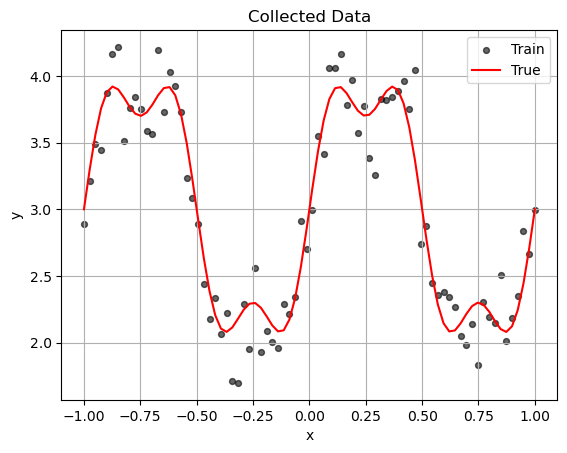

In [ ]:

# Parameter for data generator
NOISE_STD = 0.2
N = 80

# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Plot data
plt.scatter(Xtr.cpu(), Ytr.cpu(), s=18, color='k', alpha=0.6, label='Train')
plt.plot(Xgrid.cpu(), f(Xgrid.cpu()), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()

In [ ]:
# Likelihood + model
likelihood2 = gpytorch.likelihoods.GaussianLikelihood().to(device)
model2 = ExactGPModel(Xtr, Ytr, likelihood2).to(device)

iter    1 | loss 1.279 | lengthscale 0.668 | noise 0.6686
iter  200 | loss 0.481 | lengthscale 0.386 | noise 0.0899
iter  400 | loss 0.476 | lengthscale 0.402 | noise 0.0898
iter  600 | loss 0.474 | lengthscale 0.410 | noise 0.0898
iter  800 | loss 0.473 | lengthscale 0.416 | noise 0.0898


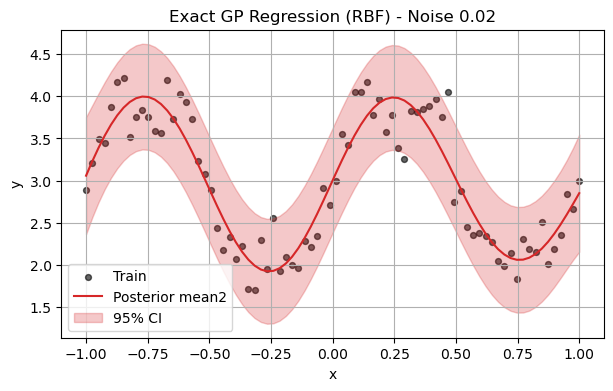

In [ ]:
# ---------- Train (maximize log marginal likelihood2) ----------
trainmodel(model2, likelihood2, Xtr, Ytr, training_iter=800)

# ---------- Evaluate ----------
x2_2 = torch.linspace(-1, 1, N).to(device)
model2.eval()
likelihood2.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred2 = likelihood2(model2(x2_2))
    mean2 = pred2.mean.cpu()
    lower2, upper2 = pred2.confidence_region()
    lower2, upper2 = lower2.cpu(), upper2.cpu()

x2_2 = x2_2.cpu().squeeze()
Ytr_cpu2 = Ytr.cpu()
Xtr_cpu2 = Xtr.cpu().squeeze()

# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu2, Ytr_cpu2, s=18, color='k', alpha=0.6, label='Train')
plt.plot(x2_2, mean2, label='Posterior mean2', color='C3')
plt.fill_between(x2_2, lower2, upper2, alpha=0.25, label='95% CI', color='C3')
plt.title('Exact GP Regression (RBF) - Noise 0.02')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()


- *Comparison*

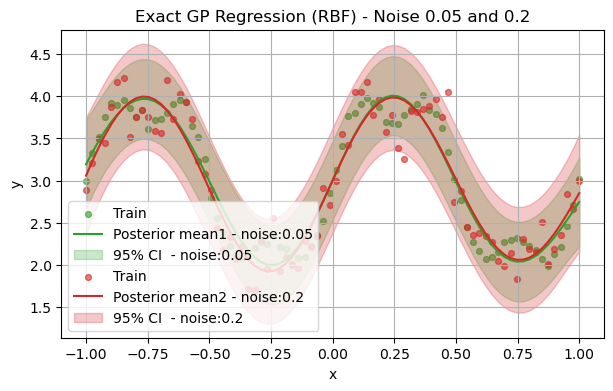

In [ ]:
# ---------- Plot ----------

plt.figure(figsize=(7,4))

plt.scatter(Xtr_cpu1, Ytr_cpu1, s=18, color='C2', alpha=0.6, label='Train')
plt.plot(x2_1, mean1, label='Posterior mean1 - noise:0.05', color='C2')
plt.fill_between(x2_1, lower1, upper1, alpha=0.25, label='95% CI  - noise:0.05', color='C2')

plt.scatter(Xtr_cpu2, Ytr_cpu2, s=18, color='C3', alpha=0.6, label='Train')
plt.plot(x2_2, mean2, label='Posterior mean2 - noise:0.2', color='C3')
plt.fill_between(x2_2, lower2, upper2, alpha=0.25, label='95% CI  - noise:0.2', color='C3')

plt.title('Exact GP Regression (RBF) - Noise 0.05 and 0.2')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()


In [ ]:
for noise in [0.05, 0.2]:
    print(f"\n=== Training with noise_std = {noise} ===")
    Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=noise)
    Xtr, Ytr = Xtr.to(device), Ytr.to(device)

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(Xtr, Ytr, likelihood).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train(); likelihood.train()
    for i in range(500):
        optimizer.zero_grad()
        output = model(Xtr)
        loss = -mll(output, Ytr)
        loss.backward()
        optimizer.step()
    print(f"Learned lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f}")
    print(f"Learned noise: {likelihood.noise.item():.4f}")



=== Training with noise_std = 0.05 ===
Learned lengthscale: 0.411
Learned noise: 0.0493

=== Training with noise_std = 0.2 ===
Learned lengthscale: 0.397
Learned noise: 0.0941


What we see is that with noise of 0.2 GP is learning a larger likelihood, that's the reason the lenghscale is wider. With less noise (0.05) the model trust more the data (the curve is more adjusted) also the lenghtscale decreases, is more narrow, the model is more flexible.

### Part C — Extrapolation behavior

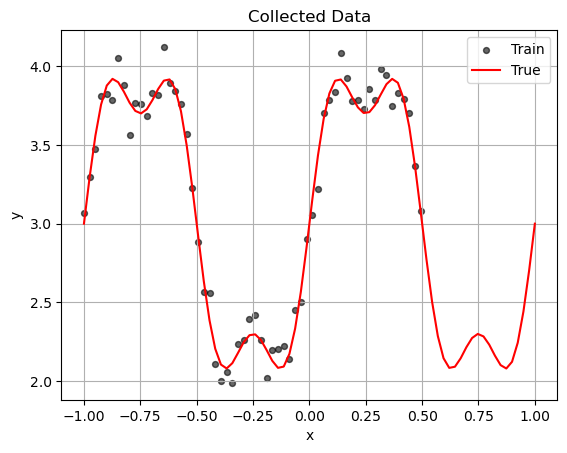

In [ ]:
# Parameter for data generator
NOISE_STD = 0.1
N = 80

# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=True)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)

# Plot data
plt.scatter(Xtr.cpu(), Ytr.cpu(), s=18, color='k', alpha=0.6, label='Train')
plt.plot(Xgrid.cpu(), f(Xgrid.cpu()), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()

In [ ]:
# ---------- Exact GP model - Linear mean ----------
class ExactGPModelLinearMean(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # TODO (Part A): pick a mean; start with ZeroMean (try Constant/Linear in Part C)
        self.mean_module = gpytorch.means.LinearMean(1)
        # TODO (Part A): kernel = ScaleKernel(RBFKernel)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Likelihood + model
likelihood1 = gpytorch.likelihoods.GaussianLikelihood().to(device)
likelihood2 = gpytorch.likelihoods.GaussianLikelihood().to(device)
model1 = ExactGPModel(Xtr, Ytr, likelihood1).to(device)
model2 = ExactGPModelLinearMean(Xtr, Ytr, likelihood2).to(device)

In [ ]:
# ---------- Train model 1 (maximize log marginal likelihood) ----------
trainmodel(model1, likelihood1, Xtr, Ytr, training_iter=800)

# ---------- Evaluate ----------
x2 = torch.linspace(-1, 1, N).to(device)
model1.eval()
likelihood1.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred1 = likelihood1(model1(x2))
    mean1 = pred1.mean.cpu()
    lower1, upper1 = pred1.confidence_region()
    lower1, upper1 = lower1.cpu(), upper1.cpu()

x2 = x2.cpu().squeeze()
Ytr_cpu_1 = Ytr.cpu()
Xtr_cpu_1 = Xtr.cpu().squeeze()



# ---------- Train model 2 (maximize log marginal likelihood) ----------
trainmodel(model2, likelihood2, Xtr, Ytr, training_iter=800)

# ---------- Evaluate ----------
x2 = torch.linspace(-1, 1, N).to(device)
model2.eval()
likelihood2.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred2 = likelihood2(model2(x2))
    mean2 = pred2.mean.cpu()
    lower2, upper2 = pred2.confidence_region()
    lower2, upper2 = lower2.cpu(), upper2.cpu()

x2 = x2.cpu().squeeze()
Ytr_cpu_2 = Ytr.cpu()
Xtr_cpu_2 = Xtr.cpu().squeeze()


iter    1 | loss 0.224 | lengthscale 0.396 | noise 0.0485
iter  200 | loss 0.224 | lengthscale 0.412 | noise 0.0509
iter  400 | loss 0.224 | lengthscale 0.412 | noise 0.0509
iter  600 | loss 0.224 | lengthscale 0.412 | noise 0.0509
iter  800 | loss 0.224 | lengthscale 0.412 | noise 0.0509
iter    1 | loss -0.337 | lengthscale 0.135 | noise 0.0107
iter  200 | loss -0.337 | lengthscale 0.129 | noise 0.0102
iter  400 | loss -0.337 | lengthscale 0.129 | noise 0.0102
iter  600 | loss -0.337 | lengthscale 0.129 | noise 0.0102
iter  800 | loss -0.337 | lengthscale 0.129 | noise 0.0102


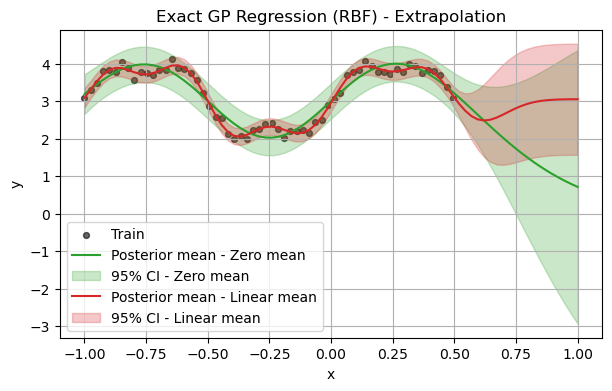

In [ ]:

# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu_1, Ytr_cpu_1 , s=18, color='k', alpha=0.6, label='Train')
plt.plot(x2, mean1, label='Posterior mean - Zero mean', color='C2')
plt.fill_between(x2, lower1, upper1, alpha=0.25, label='95% CI - Zero mean', color='C2')

plt.plot(x2, mean2, label='Posterior mean - Linear mean', color='C3')
plt.fill_between(x2, lower2, upper2, alpha=0.25, label='95% CI - Linear mean', color='C3')


plt.title('Exact GP Regression (RBF) - Extrapolation')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()



- *Comparison*

The GP with zero mean tends to return to zero for unknown regions, while GP with linear mean will extend better the leaned tendency (better extrapolation).

### Part D — (Graduate level) Sparse GP with inducing points

In [ ]:
import time
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution

In [ ]:
# ---------- variational inducing-point GP (SVGP) ----------
class SVGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Variational distribution and estrategy
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:

# ================================
# Training SVGP
# ================================
M = 64  # número de puntos de inducción
inducing_points = torch.linspace(-1, 1, M).unsqueeze(-1).to(device)

likelihood_sv = gpytorch.likelihoods.GaussianLikelihood().to(device)
model_sv = SVGPModel(inducing_points).to(device)
# ExactGPModel(Xtr, Ytr, likelihood1).to(device)

model_sv.train()
likelihood_sv.train()

optimizer = torch.optim.Adam([
    {'params': model_sv.parameters()},
    {'params': likelihood_sv.parameters()}
], lr=0.05)

# Variational ELBO (objective)
mll = gpytorch.mlls.VariationalELBO(likelihood_sv, model_sv, num_data=Ytr.size(0))

start_time = time.time()
training_iter = 800
for i in range(training_iter):
    optimizer.zero_grad()
    output = model_sv(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()

    if (i + 1) % 200 == 0 or i == 0:
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")

elapsed = time.time() - start_time
print(f"Training time (SVGP): {elapsed:.2f} seconds")

Iter 1/800 - Loss: 9.160
Iter 200/800 - Loss: 0.687
Iter 400/800 - Loss: 0.262
Iter 600/800 - Loss: 0.300
Iter 800/800 - Loss: 0.276
Training time (SVGP): 5.54 seconds


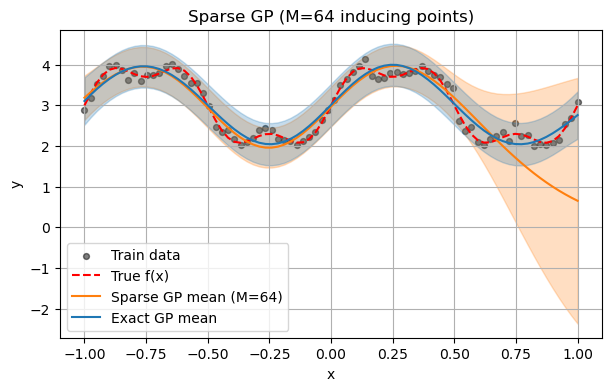

In [ ]:
# ================================
# Evaluate
# ================================
model_sv.eval()
likelihood_sv.eval()

with torch.no_grad():
    pred_sv = likelihood_sv(model_sv(Xgrid))
    mean_sv = pred_sv.mean.cpu()
    lower_sv, upper_sv = pred_sv.confidence_region()
    lower_sv, upper_sv = lower_sv.cpu(), upper_sv.cpu()

# Plot
plt.figure(figsize=(7,4))

# True data
plt.scatter(Xtr.cpu(), Ytr.cpu(), s=18, color='k', alpha=0.5, label='Train data')
plt.plot(Xgrid.cpu(), f(Xgrid.cpu()), 'r--', label='True f(x)')

# Sparse GP (SVGP)
plt.plot(Xgrid.cpu(), mean_sv, 'C1', label=f'Sparse GP mean (M={M})')
plt.fill_between(Xgrid.cpu().squeeze(), lower_sv, upper_sv, color='C1', alpha=0.25)

# Exact GP
plt.plot(x2, mean, label='Exact GP mean', color='C0')
plt.fill_between(x2, lower, upper, alpha=0.25, color='C0')


plt.title(f"Sparse GP (M={M} inducing points)")
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True)
plt.show()


- *Discussion*

As it can be seen, with some M=64 the approximation is similiar to Exact GP. Exact GP will tend to go back to zero, while Sparse GP will be wider at the ends.


=== N = 40 ===
Exact GP time: 0.83s
Sparse GP time: 2.18s

=== N = 80 ===
Exact GP time: 0.76s
Sparse GP time: 2.15s

=== N = 160 ===
Exact GP time: 0.83s
Sparse GP time: 2.24s

=== N = 320 ===
Exact GP time: 0.87s
Sparse GP time: 2.18s

=== N = 640 ===
Exact GP time: 0.94s
Sparse GP time: 2.19s

=== N = 1280 ===
Exact GP time: 4.76s
Sparse GP time: 2.30s


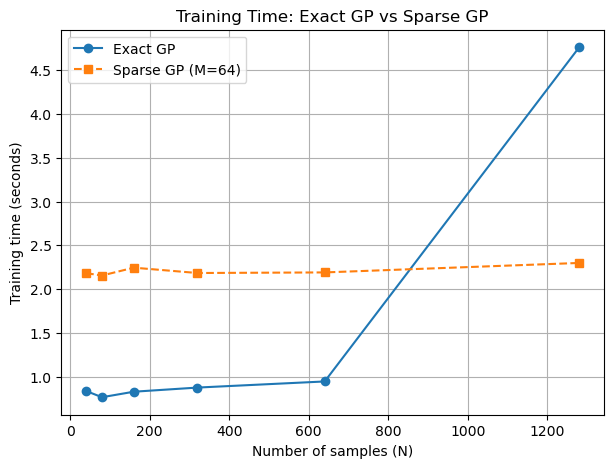

In [ ]:
# ======================================================
# Compare training time: Exact GP vs Sparse GP (SVGP)
# ======================================================
import time

# Config
Ns = [40, 80, 160, 320, 640, 1280]   # distintos tamaños de dataset
M = 64                    # número de puntos de inducción para SVGP
NOISE_STD = 0.1
results_exact, results_sv = [], []

for N in Ns:
    print(f"\n=== N = {N} ===")

    # ----- Datos -----
    Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD)
    Xtr, Ytr = Xtr.to(device), Ytr.to(device)

    # ----- Exact GP -----
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModelLinearMean(Xtr, Ytr, likelihood).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train(); likelihood.train()
    start = time.time()
    for i in range(300):
        optimizer.zero_grad()
        output = model(Xtr)
        loss = -mll(output, Ytr)
        loss.backward()
        optimizer.step()
    elapsed_exact = time.time() - start
    results_exact.append(elapsed_exact)
    print(f"Exact GP time: {elapsed_exact:.2f}s")

    # ----- Sparse GP (SVGP) -----
    inducing_points = torch.linspace(-1, 1, M).unsqueeze(-1).to(device)
    likelihood_sv = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model_sv = SVGPModel(inducing_points).to(device)
    optimizer_sv = torch.optim.Adam([
        {'params': model_sv.parameters()},
        {'params': likelihood_sv.parameters()}
    ], lr=0.05)
    mll_sv = gpytorch.mlls.VariationalELBO(likelihood_sv, model_sv, num_data=Ytr.size(0))

    model_sv.train(); likelihood_sv.train()
    start = time.time()
    for i in range(300):
        optimizer_sv.zero_grad()
        output_sv = model_sv(Xtr)
        loss_sv = -mll_sv(output_sv, Ytr)
        loss_sv.backward()
        optimizer_sv.step()
    elapsed_sv = time.time() - start
    results_sv.append(elapsed_sv)
    print(f"Sparse GP time: {elapsed_sv:.2f}s")

# ======================================================
# Plot results
# ======================================================
plt.figure(figsize=(7,5))
plt.plot(Ns, results_exact, 'o-', label='Exact GP')
plt.plot(Ns, results_sv, 's--', label=f'Sparse GP (M={M})')
plt.xlabel('Number of samples (N)')
plt.ylabel('Training time (seconds)')
plt.title('Training Time: Exact GP vs Sparse GP')
plt.grid(True)
plt.legend()
plt.show()


*Short write-up (≤1 page, as a cell in the notebook):*


- What did increasing noise do to learned hyperparameters and uncertainty?
    - When the observation noise is increased , the GP model learn a higher value of likelihood.noise and the uncertainty bands are wider, the mean prediction became smoother and less tightly fitted to the training points. With lower noise, the GP trusted the data more — producing a sharper fit and narrower confidence intervals.
- How does the kernel lengthscale affect fit and confidence?
    - The kernel.lengthscale controls how rapidly the GP function can vary with input changes. A small lengthscale allows rapid changes and fits fine details, while a large lengthscale enforces smoother variations across x. Models with smaller lengthscales fit the training data closely but may overfit noise, whereas larger lengthscales produce smoother fits with broader uncertainty, especially between sparse data points.
- Why does the GP behave the way it does when extrapolating? How did the mean function change that?
    - Outside the training region, the GP tends to revert to its prior mean function. With a ZeroMean, predictions return toward zero with high uncertainty BECAUSE the model assumes the function is zero where no data are observed,adding a LinearMean provides a more informed prior, allowing the GP to extrapolate following the learned trend instead of decaying to zero. This significantly improved extrapolation beyond x=0.5.
- (Grad level) Sparse vs Exact: trade-offs you observed
    - The Exact GP provides a more accurate posterior but scales cubically with the number of training samples. In contrast, the Sparse GP (SVGP) approximates the full covariance using a limited set of inducing points reducing the complexity. With moderate M, the SVGP produced predictions very close to the Exact GP but trained much faster as N increased. However, if M is too small, the approximation loses local detail and underestimates uncertainty in complex regions, it's a trade-off between speed and fidelity.

---
---
---

## Exercise 2 (Optional, except PhD students): Model-Based Reinforcement Learning with Gaussian Process + MPC
***Goal:***
Learn the core ideas of **Model-Based Reinforcement Learning (MBRL)** by:
- Learning a **dynamics model** with a Gaussian Process (GP)
- Using **Model Predictive Control (MPC)** to plan actions
- Comparing against random or fixed policies

We’ll use a simplified version of **GP-MPC** (similar in spirit to PILCO or PETS) on the *MountainCarContinuous-v0* task.

---

## 1 Background
The system dynamics are unknown.  
We collect transitions
\[
(x_t, u_t, r_t, x_{t+1})
\]
and learn a GP model of the change in state:
\[
\Delta x = f(x_t, u_t) + \varepsilon
\]
Then, given a current state, we **simulate** future trajectories using the GP mean prediction and pick an action sequence that maximizes the expected reward (or minimizes cost) over a short horizon — the **MPC** loop.

---

## 2 Steps

### Part A — Collect data with a random policy
1. Run `N = 1000` random actions.
2. Store transitions \((x_t, u_t, x_{t+1})\).
3. Compute state differences:  
   `dx = x_next - x`.

### Part B — Train a Gaussian Process model
1. Fit a GP for each state dimension (here 2: position and velocity).  
   Inputs = `[x_t, u_t]`  
   Outputs = `dx_t`
2. Use **GPyTorch** or **sklearn.gaussian_process**.
3. Plot model predictions vs. ground truth for a few samples.

### Part C — Implement a simple MPC controller
1. At each step:
   - Start from current state \(x_t\).
   - Sample \(K\) random control sequences of horizon \(H\).
   - For each sequence, **simulate forward** using GP predictions.
   - Compute cumulative reward (from MountainCarContinuous env).
   - Execute the *first action* of the best sequence.
2. Repeat until termination or max steps.

### Part D — Evaluate and visualize
1. Plot the car’s trajectory (position vs. time).
2. Compare with random policy performance.
3. Discuss:  
   - How does the GP model’s accuracy affect control?  
   - How many random samples or planning horizon are needed?

---

## Deliverables
- Code for data collection, GP training, and MPC loop.
- Plots:
  - GP predictions vs. true next states.
  - Car’s position vs. time during control.
- Short discussion (≈½ page):
  - How did planning horizon affect performance?
  - How does GP uncertainty limit long-term planning?

---

## Optional extensions
- Add GP uncertainty penalty in cost function.
- Try a learned NN model instead of GP.
- Use warm-start data from a heuristic controller.
- Compare Exact GP vs. Sparse GP (SVGP).

---

## Hints
- Normalize inputs and outputs before GP training.
- Use a small horizon (H≈15–20) for efficiency.
- Reward function from environment:
  ```python
  reward = 100 * (abs(x) >= 0.45) - 0.1 * u**2

In [1]:
# ====================
# Data Collection
# ====================

import gymnasium as gym
import numpy as np

env = gym.make('MountainCarContinuous-v0')
N = 1000

X, U, dX = [], [], []

state = env.reset()[0]
for _ in range(N):
    action = env.action_space.sample()
    next_state, _, done, _, _ = env.step(action)
    X.append(np.hstack([state, action]))
    dX.append(next_state - state)
    U.append(action)
    if done:
        state = env.reset()[0]
    else:
        state = next_state

X, dX = np.array(X), np.array(dX)

In [2]:
# =================================
# Train the Gaussian Process Model
# =================================

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)

gps = []
for i in range(dX.shape[1]):  # one GP per state dimension
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(X, dX[:, i])
    gps.append(gp)

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


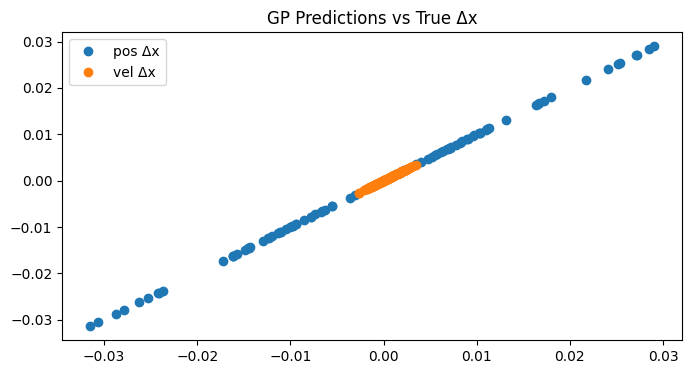

In [3]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(X), 100)
preds = [gp.predict(X[idx]) for gp in gps]
plt.figure(figsize=(8,4))
plt.plot(dX[idx,0], preds[0], 'o', label='pos Δx')
plt.plot(dX[idx,1], preds[1], 'o', label='vel Δx')
plt.legend(); plt.title('GP Predictions vs True Δx')
plt.show()


In [4]:
# ====================
# MPC Controller
# ====================

def simulate_sequence(state, seq, gps, horizon=15):
    total_reward = 0
    x = state.copy()
    for u in seq:
        inp = np.hstack([x, u.reshape(1)])
        dx_pred = np.array([gp.predict(inp.reshape(1, -1))[0] for gp in gps])
        x = x + dx_pred
        # reward function from MountainCarContinuous
        reward = 100 * (abs(x[0]) >= 0.45) - 0.1 * (u**2)
        total_reward += reward
    return total_reward

def mpc_control(env, gps, H=15, K=200, max_steps=1000):
    state = env.reset()[0]
    done = False
    traj = []
    step = 0

    while not done and step < max_steps:
        seqs = np.random.uniform(-1, 1, size=(K, H, 1))
        rewards = [simulate_sequence(state, seq, gps, H) for seq in seqs]
        best_seq = seqs[np.argmax(rewards)]
        action = best_seq[0]

        next_state, _, done, _, _ = env.step(action)
        traj.append(state[0])

        # ✅ print progress every few steps
        if step % 10 == 0:
            print(f"Step {step:4d} | Best reward: {np.max(rewards):7.2f} | Position: {state[0]:.3f}")

        state = next_state
        step += 1

    print("\n✅ MPC control finished. Total steps:", step)
    return traj


traj_gp = mpc_control(env, gps, H=25, K=500, max_steps=1000)


Step    0 | Best reward: 2099.17 | Position: -0.423
Step   10 | Best reward: 2499.54 | Position: -0.498
Step   20 | Best reward: 2499.62 | Position: -0.622
Step   30 | Best reward: 2499.62 | Position: -0.701
Step   40 | Best reward: 2499.32 | Position: -0.688
Step   50 | Best reward: 2499.19 | Position: -0.605
Step   60 | Best reward: 2499.31 | Position: -0.489
Step   70 | Best reward: 2499.62 | Position: -0.453
Step   80 | Best reward: 2499.65 | Position: -0.469
Step   90 | Best reward: 2499.59 | Position: -0.502
Step  100 | Best reward: 2499.64 | Position: -0.549
Step  110 | Best reward: 2499.58 | Position: -0.576
Step  120 | Best reward: 2499.66 | Position: -0.562
Step  130 | Best reward: 2499.76 | Position: -0.530
Step  140 | Best reward: 2499.62 | Position: -0.516
Step  150 | Best reward: 2499.53 | Position: -0.532
Step  160 | Best reward: 2499.54 | Position: -0.546
Step  170 | Best reward: 2499.52 | Position: -0.565
Step  180 | Best reward: 2499.48 | Position: -0.577
Step  190 | 

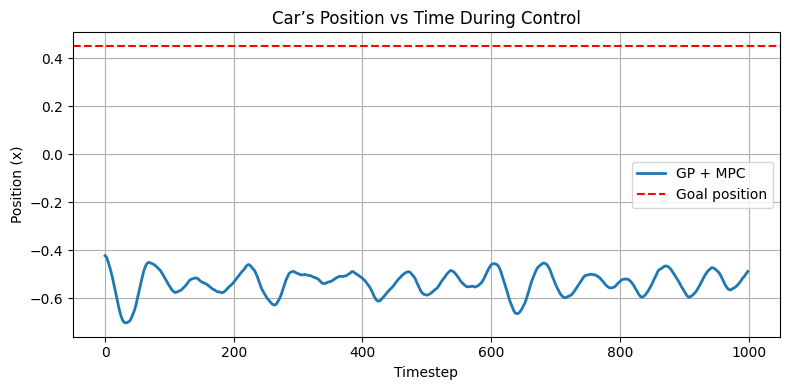

In [5]:
# ====================
# Visualization
# ====================

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

# Gráfica del MPC con GP
plt.plot(traj_gp, label="GP + MPC", linewidth=2)

plt.axhline(0.45, color='r', linestyle='--', label='Goal position')
plt.xlabel("Timestep")
plt.ylabel("Position (x)")
plt.title("Car’s Position vs Time During Control")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Using Neural Networks

In [6]:
# ====================
# Data Collection - NN
# ====================

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.


import gymnasium as gym
import numpy as np

env = gym.make("MountainCarContinuous-v0")
N = 1000

X, dX = [], []
state = env.reset()[0]

for _ in range(N):
    action = env.action_space.sample()
    next_state, _, done, _, _ = env.step(action)
    X.append(np.hstack([state, action]))
    dX.append(next_state - state)
    if done:
        state = env.reset()[0]
    else:
        state = next_state

X, dX = np.array(X, dtype=np.float32), np.array(dX, dtype=np.float32)

In [7]:
# =================================
# Train the Gaussian Process Model - NN
# =================================

import torch
import torch.nn as nn
import torch.optim as optim

# Convertir datos a tensores
X_t = torch.tensor(X)
dX_t = torch.tensor(dX)

# Modelo dinámico
class DynamicsNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )
    def forward(self, x):
        return self.net(x)

model = DynamicsNN(in_dim=X.shape[1], out_dim=dX.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Entrenamiento
for epoch in range(200):
    pred = model(X_t)
    loss = loss_fn(pred, dX_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.5f}")


Epoch 000 | Loss: 0.00544
Epoch 020 | Loss: 0.00010
Epoch 040 | Loss: 0.00004
Epoch 060 | Loss: 0.00002
Epoch 080 | Loss: 0.00002
Epoch 100 | Loss: 0.00002
Epoch 120 | Loss: 0.00002
Epoch 140 | Loss: 0.00002
Epoch 160 | Loss: 0.00002
Epoch 180 | Loss: 0.00001


In [8]:
# ====================
# MPC Controller - NN
# ====================

def simulate_sequence_nn(state, seq, model, horizon=15):
    total_reward = 0
    x = torch.tensor(state, dtype=torch.float32)
    for u in seq:
        inp = torch.cat([x, torch.tensor(u, dtype=torch.float32)])
        dx_pred = model(inp)
        x = x + dx_pred
        reward = 100 * (abs(x[0].item()) >= 0.45) - 0.1 * (u**2)
        total_reward += reward
    return total_reward

def mpc_control_nn(env, model, H=15, K=100, max_steps=300, render=True):
    state = env.reset()[0]
    done = False
    traj = []
    step = 0

    while not done and step < max_steps:
        seqs = np.random.uniform(-1, 1, size=(K, H, 1))
        rewards = [simulate_sequence_nn(state, seq, model, H) for seq in seqs]
        best_seq = seqs[np.argmax(rewards)]
        action = best_seq[0]

        next_state, _, done, _, _ = env.step(action)
        traj.append(state[0])

        if render and step % 5 == 0:
            env.render()

        state = next_state
        step += 1

    env.close()
    return traj

traj_nn = mpc_control_nn(env, model, H=10, K=50, max_steps=1000)

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/classic_control/continuous_mountain_car.py:202: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
  gym.logger.warn(


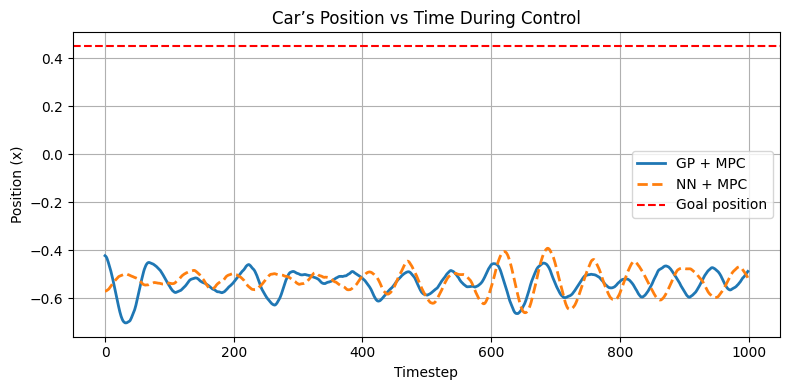

In [9]:
# ====================
# Visualization - NN
# ====================

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

# Gráfica del MPC con GP
plt.plot(traj_gp, label="GP + MPC", linewidth=2)

# Si tienes otras políticas, puedes añadirlas:
plt.plot(traj_nn, '--', label="NN + MPC", linewidth=2)
# plt.plot(traj_random, ':', label="Random Policy")

plt.axhline(0.45, color='r', linestyle='--', label='Goal position')
plt.xlabel("Timestep")
plt.ylabel("Position (x)")
plt.title("Car’s Position vs Time During Control")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Discussion

With the Gaussian Process the planning horizon (H) strongly influenced controller performance.
With short horizons (H ≤ 10), both GP and NN versions of MPC behaved myopically, failing to generate the backward–forward motion required to reach the hilltop.
Increasing the horizon to 20–30 steps improved long-term planning, allowing smoother and more purposeful trajectories.
However, the GP model became unstable for large H due to error accumulation, while the NN model remained more robust though less precise locally.
Overall, intermediate horizons (≈20 steps) provided the best balance between foresight and reliability.

Regarding uncertainty, the GP explicitly models predictive variance, giving confidence estimates that are useful for safety-aware control.
Yet, its uncertainty grows quickly outside the training region, limiting reliable long-term planning.
The NN model lacks explicit uncertainty but generalizes better to unseen states, enabling longer simulations without divergence.
In summary, GP + MPC is more accurate and sample-efficient for short-term control, while NN + MPC scales better, tolerates longer horizons, and runs faster, though without uncertainty quantification.

## Exercise 3: Getting Started with MuJoCo and XML Models
***Goal:***
The goal of this exercise is to **install MuJoCo**, explore its **Python interface**, and learn the structure of **MJCF (XML) models** used to describe robots and environments.  
By the end, you should be able to:
- Run a MuJoCo simulation locally  
- Open, modify, and reload a simple XML model  
- Use Google Colab connected to your local runtime

---

MuJoCo (“Multi-Joint dynamics with Contact”) is a fast physics engine widely used in robotics and reinforcement learning.  
It uses XML (MJCF files) to describe bodies, joints, sensors, and actuators.

In this exercise, you will:
1. Install MuJoCo on your computer  
2. Install and run Jupyter Notebook or Lab  
3. Connect Colab to your local runtime  
4. Run Mujco with existent XML (car, quadrotor, mountain)
6. Create a scene with multiple falling objects

---
## Step-by-Step Instructions
### 1 Install MuJoCo: Download and install
- Visit [https://mujoco.org/download](https://mujoco.org/download)  
- Choose the installer for your OS (Windows, macOS, or Linux)

### 2 Install Jupyter

You can use either JupyterLab or Jupyter Notebook

```
pip install jupyterlab
```

Run
```
jupyter lab
```
This should open your browser at:
```
http://localhost:8888/lab
```

### 3 Configure Google Colab to Run Locally

### 4 Run a Simple MuJoCo Simulation


In [ ]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import os

XML = r"""
<mujoco>
	<worldbody>
        <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
		<geom type="plane" size="1 1 0.1" rgba=".9 0 0 1"/>
		<body pos="0 0 1">
			<joint type="free"/>
			<geom type="box" size=".1 .2 .3" rgba="0 .9 0 1"/>
		</body>
	</worldbody>
</mujoco>
"""


simend = 15 #simulation time


# For callback functions
button_left = False
button_middle = False
button_right = False
lastx = 0
lasty = 0

def init_controller(model,data):
    #initialize the controller here. This function is called once, in the beginning
    pass

def controller(model, data):
    #put the controller here. This function is called inside the simulation.
    pass

def keyboard(window, key, scancode, act, mods):
    if act == glfw.PRESS and key == glfw.KEY_BACKSPACE:
        mj.mj_resetData(model, data)
        mj.mj_forward(model, data)

def mouse_button(window, button, act, mods):
    # update button state
    global button_left
    global button_middle
    global button_right

    button_left = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_LEFT) == glfw.PRESS)
    button_middle = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_MIDDLE) == glfw.PRESS)
    button_right = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_RIGHT) == glfw.PRESS)

    # update mouse position
    glfw.get_cursor_pos(window)

def mouse_move(window, xpos, ypos):
    # compute mouse displacement, save
    global lastx
    global lasty
    global button_left
    global button_middle
    global button_right

    dx = xpos - lastx
    dy = ypos - lasty
    lastx = xpos
    lasty = ypos

    # no buttons down: nothing to do
    if (not button_left) and (not button_middle) and (not button_right):
        return

    # get current window size
    width, height = glfw.get_window_size(window)

    # get shift key state
    PRESS_LEFT_SHIFT = glfw.get_key(
        window, glfw.KEY_LEFT_SHIFT) == glfw.PRESS
    PRESS_RIGHT_SHIFT = glfw.get_key(
        window, glfw.KEY_RIGHT_SHIFT) == glfw.PRESS
    mod_shift = (PRESS_LEFT_SHIFT or PRESS_RIGHT_SHIFT)

    # determine action based on mouse button
    if button_right:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_MOVE_H
        else:
            action = mj.mjtMouse.mjMOUSE_MOVE_V
    elif button_left:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_ROTATE_H
        else:
            action = mj.mjtMouse.mjMOUSE_ROTATE_V
    else:
        action = mj.mjtMouse.mjMOUSE_ZOOM

    mj.mjv_moveCamera(model, action, dx/height,
                      dy/height, scene, cam)

def scroll(window, xoffset, yoffset):
    action = mj.mjtMouse.mjMOUSE_ZOOM
    mj.mjv_moveCamera(model, action, 0.0, -0.05 *
                      yoffset, scene, cam)

# MuJoCo data structures
model = mj.MjModel.from_xml_string(XML)  # MuJoCo model
data = mj.MjData(model)                # MuJoCo data
cam = mj.MjvCamera()                        # Abstract camera
opt = mj.MjvOption()                        # visualization options

# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(1200, 900, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, keyboard)
glfw.set_cursor_pos_callback(window, mouse_move)
glfw.set_mouse_button_callback(window, mouse_button)
glfw.set_scroll_callback(window, scroll)


#initialize the controller
init_controller(model,data)

#set the controller
mj.set_mjcb_control(controller)

while not glfw.window_should_close(window):
    time_prev = data.time

    while (data.time - time_prev < 1.0/60.0):
        mj.mj_step(model, data)

    if (data.time>=simend):
        break

    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(
        window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam,
                       mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()

glfw.terminate()


# Test with the following XMLs

In [ ]:
# CAR
XML_car = r"""
<mujoco model="simple_car_gazebo_style">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.12"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="40 40"
              specular="0.05" shininess="0.3" reflectance="0.2" rgba="1 1 1 1"/>
    <material name="chassis_mat" rgba="0.12 0.30 0.75 1" specular="0.2" shininess="0.4"/>
    <material name="tire_mat"    rgba="0.07 0.07 0.07 1" specular="0.05" shininess="0.2"/>
  </asset>

  <default>
    <!-- No default rgba here; let materials show through -->
    <geom contype="1" conaffinity="1" friction="1.0 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun_dir" directional="true" castshadow="true"
           pos="0 0 5" dir="0.2 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="0 0 3" dir="-0.3 -0.2 -1" diffuse="0.3 0.3 0.35" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <geom name="floor" type="plane" pos="0 0 0" size="20 20 0.1" material="ground_mat"/>

    <!-- Chassis center at z=0.22 = wheel_radius(0.10)+half_chassis(0.10)+clearance(0.02) -->
    <body name="chassis" pos="0 0 0.22">
      <freejoint name="chassis_free"/>
      <geom name="chassis_box" type="box" size="0.40 0.25 0.10" material="chassis_mat"/>

      <!-- Wheel radius=0.10; centers should be at absolute z=0.10.
           Relative z offset = 0.10 - 0.22 = -0.12 (below chassis center). -->
      <!-- Cylinder axis along y: rotate +90deg about x -->
      <body name="wheel_fl" pos=" 0.35  0.22 -0.12">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_fr" pos=" 0.35 -0.22 -0.12">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rl" pos="-0.35  0.22 -0.12">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rr" pos="-0.35 -0.22 -0.12">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name="m_fl" joint="j_fl" gear="120"/>
    <motor name="m_fr" joint="j_fr" gear="120"/>
    <motor name="m_rl" joint="j_rl" gear="120"/>
    <motor name="m_rr" joint="j_rr" gear="120"/>
  </actuator>
</mujoco>



"""

In [ ]:
## Drone
XML_drone = r"""
<mujoco model="quad2d">
  <option gravity="0 0 -9.81" timestep="0.005"/>
  <worldbody>
    <body name="quad" pos="0 0 1">
      <!-- 2D DOF -->
      <joint name="x"     type="slide" axis="1 0 0" limited="false"/>
      <joint name="z"     type="slide" axis="0 0 1" limited="false"/>
      <joint name="pitch" type="hinge" axis="0 1 0" limited="false"/>

      <!-- frame -->
      <geom type="box" size="0.15 0.02 0.01" rgba="0.2 0.5 0.8 1"/>

      <!-- thruster sites (±arm) -->
      <site name="left"  pos="-0.15 0 0" size="0.01" rgba="1 0 0 1"/>
      <site name="right" pos="+0.15 0 0" size="0.01" rgba="0 1 0 1"/>

      <!-- mass/inertia (defaults are fine for demo) -->
      <inertial pos="0 0 0" mass="0.6" diaginertia="0.002 0.002 0.004"/>
    </body>

    <!-- ground plane -->
    <geom name="ground" type="plane" pos="0 0 0" size="5 5 0.1" rgba="0.8 0.8 0.8 1"/>
  </worldbody>

<actuator>
  <!-- Control u in [0, 20]; actual applied force = gainprm[0] * u along gear direction -->
  <general name="thrust_left"  site="left"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>

  <general name="thrust_right" site="right"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>
</actuator>


  <sensor>
    <framepos    name="pos"  objtype="body" objname="quad"/>
    <frameangvel name="omega" objtype="body" objname="quad"/>
    <framelinvel name="vlin"  objtype="body" objname="quad"/>
  </sensor>
</mujoco>
"""

In [ ]:
# Mountain

XML_mountain = r"""
<mujoco model="car_on_piecewise_curved_ramp">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.10"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="12 2"
              specular="0.05" shininess="0.3" reflectance="0.08" rgba="1 1 1 1"/>

    <!-- Car materials -->
    <material name="paint" rgba="0.10 0.22 0.70 1" specular="0.45" shininess="0.7" reflectance="0.10"/>
    <material name="glass" rgba="0.20 0.28 0.35 0.35" specular="0.6" shininess="0.8" reflectance="0.1"/>
    <material name="tire"  rgba="0.06 0.06 0.06 1" specular="0.05" shininess="0.2"/>
    <material name="rim"   rgba="0.85 0.85 0.88 1" specular="0.6" shininess="0.8"/>
    <material name="black" rgba="0.04 0.04 0.05 1" specular="0.1" shininess="0.2"/>
  </asset>

  <default>
    <geom contype="1" conaffinity="1" friction="1.3 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun" directional="true" castshadow="true"
           pos="0 0 8" dir="0.25 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="-2 -2 4" dir="0.3 0.1 -1" diffuse="0.35 0.35 0.4" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <camera name="valley_view" mode="fixed" pos="-3.2 -1.2 1.3" euler="0.12 0.42 0.8" fovy="45"/>

    <!-- ========= Piecewise-curved ramp (sign-corrected pitches) =========
         z(x) = 0.15 x^2  ->  dz/dx = 0.30 x  ->  pitch θy = -atan(0.30 x)
         Centers at x = [-2.25, -1.75, -1.25, -0.75, -0.25, 0, 0.25, 0.75, 1.25, 1.75, 2.25]
    -->
    <geom name="seg_m2_25" type="box" size="0.25 1.0 0.02" pos="-2.25 0 0.759" euler="0  0.595 0" material="ground_mat"/>
    <geom name="seg_m1_75" type="box" size="0.25 1.0 0.02" pos="-1.75 0 0.459" euler="0  0.487 0" material="ground_mat"/>
    <geom name="seg_m1_25" type="box" size="0.25 1.0 0.02" pos="-1.25 0 0.234" euler="0  0.358 0" material="ground_mat"/>
    <geom name="seg_m0_75" type="box" size="0.25 1.0 0.02" pos="-0.75 0 0.084" euler="0  0.221 0" material="ground_mat"/>
    <geom name="seg_m0_25" type="box" size="0.25 1.0 0.02" pos="-0.25 0 0.009" euler="0  0.075 0" material="ground_mat"/>
    <geom name="seg_0"     type="box" size="0.25 1.0 0.02" pos=" 0.00 0 0.000" euler="0  0.000 0" material="ground_mat"/>
    <geom name="seg_p0_25" type="box" size="0.25 1.0 0.02" pos=" 0.25 0 0.009" euler="0 -0.075 0" material="ground_mat"/>
    <geom name="seg_p0_75" type="box" size="0.25 1.0 0.02" pos=" 0.75 0 0.084" euler="0 -0.221 0" material="ground_mat"/>
    <geom name="seg_p1_25" type="box" size="0.25 1.0 0.02" pos=" 1.25 0 0.234" euler="0 -0.358 0" material="ground_mat"/>
    <geom name="seg_p1_75" type="box" size="0.25 1.0 0.02" pos=" 1.75 0 0.459" euler="0 -0.487 0" material="ground_mat"/>
    <geom name="seg_p2_25" type="box" size="0.25 1.0 0.02" pos=" 2.25 0 0.759" euler="0 -0.595 0" material="ground_mat"/>
    <geom name="ground"    type="plane" pos="0 0 -0.02" size="10 10 0.1" material="ground_mat"/>

        <!-- Translucent narrow walls to keep the car aligned -->
    <geom name="left_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0  0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>

    <geom name="right_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0 -0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>



    <!-- ===== Car (same spec as before, slightly smaller) ===== -->
    <body name="chassis" pos="-1.5 0 0.70">
      <freejoint/>
      <geom type="box"       size="0.24 0.15 0.06" material="paint"/>
      <geom type="ellipsoid" size="0.15 0.12 0.06" pos="0.03 0 0.07" material="glass"/>
      <geom type="box"       size="0.05 0.15 0.02" pos="-0.30 0 -0.03" material="black"/>

      <!-- Wheels: radius=0.05, axle along local y -->
      <body name="wheel_fl" pos=" 0.20  0.13 -0.085">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_fr" pos=" 0.20 -0.13 -0.085">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rl" pos="-0.19  0.13 -0.085">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rr" pos="-0.19 -0.13 -0.085">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor joint="j_fl" gear="120"/>
    <motor joint="j_fr" gear="120"/>
    <motor joint="j_rl" gear="120"/>
    <motor joint="j_rr" gear="120"/>
  </actuator>
</mujoco>


"""

## Create a Scene with Falling Objects

Now let’s create a small **physics scene** to understand how MuJoCo handles **contacts and collisions**.

You’ll build an XML with **two cubes and one sphere**, stacked vertically so that they fall and collide naturally under gravity.

Add a screenshot in a cell of the notebook.

Falling Objects Scene

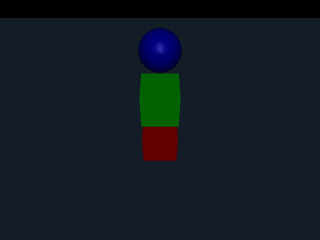

In [ ]:
import mujoco
from mujoco import MjModel, MjData, Renderer
import mediapy as media
import numpy as np

# Define XML for the scene
xml = """
<mujoco>
  <option gravity="0 0 -9.81"/>
  <worldbody>
    <!-- Ground -->
    <geom name="floor" type="plane" pos="0 0 0" size="1 1 0.1" rgba="0.2 0.3 0.4 1"/>

    <!-- First cube -->
    <body pos="0 0 0.1">
      <geom name="cube1" type="box" size="0.05 0.05 0.05" rgba="1 0 0 1"/>
    </body>

    <!-- Second cube -->
    <body pos="0 0 0.25">
      <geom name="cube2" type="box" size="0.05 0.05 0.05" rgba="0 1 0 1"/>
    </body>

    <!-- Sphere -->
    <body pos="0 0 0.4">
      <geom name="sphere" type="sphere" size="0.05" rgba="0 0 1 1"/>
    </body>
  </worldbody>
</mujoco>
"""

# Load model and data
model = MjModel.from_xml_string(xml)
data = MjData(model)

# Create a renderer
renderer = Renderer(model)

# Simulate a short duration
for _ in range(300):
    mujoco.mj_step(model, data)

# Render and display image
renderer.update_scene(data)
img = renderer.render()

media.show_image(img, title="Falling Objects Scene")

# Optionally save the image
media.write_image("falling_scene.png", img)
